In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [12]:
image_size = (150, 150)
batch_size = 32

In [3]:
# Load model
def getModel():
    model = keras.models.load_model("detectSelfie_model")
    return model

In [4]:
# Retrain model
def trainModel():
    # os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/Users/brian/Documents/BISITE/Dataset/Selfie-Image-Detection-Dataset/Training_data",
        labels="inferred",
        label_mode="int",
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/Users/brian/Documents/BISITE/Dataset/Selfie-Image-Detection-Dataset/Training_data",
        labels="inferred",
        label_mode="int",
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

    base_model = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(150, 150, 3),
        include_top=False)

    base_model.trainable = False

    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
            layers.experimental.preprocessing.RandomZoom(0.3, 0.3),
            layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        ]
    )

    inputs = keras.Input(shape=(150, 150, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation

    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2

    # Scale inputs to [-1, +1]
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])

    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`.
    x = base_model(x, training=False)

    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    # A Dense classifier with a single unit (binary classification)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[keras.metrics.BinaryAccuracy()])
    model.fit(train_ds, epochs=20, validation_data=val_ds)

    # Fine-tuning model
    base_model.trainable = True
    model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    epochs = 10
    model.fit(train_ds, epochs=epochs, validation_data=val_ds)

    # Creates a SavedModel
    model.save("detectSelfie_model")

    return model

In [5]:
def detectSelfie(image_path):
    if os.path.exists("detectSelfie_model"):
        model = getModel()
    else:
        model = trainModel()

    # Makes prediction
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = predictions[0]

    if (score > 0):
        print("Image is a Selfie")
        print(score)
        return True
    else:
        print("Image is not a Selfie")
        print(score)
        return False

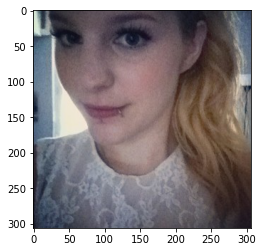

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/Users/brian/Documents/BISITE/Dataset/Selfie-Image-Detection-Dataset/Training_data/Selfie/Selfie1.jpg')
imgplot = plt.imshow(img)
plt.show()

In [9]:
detectSelfie("/Users/brian/Documents/BISITE/Dataset/Selfie-Image-Detection-Dataset/Training_data/Selfie/Selfie1.jpg")

Image is a Selfie
[12.647554]


True

In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/Users/brian/Documents/BISITE/Dataset/Selfie-Image-Detection-Dataset/Test_data",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 7862 files belonging to 2 classes.


In [17]:
class_names = test_ds.class_names
print(class_names)

['NonSelfie', 'Selfie']


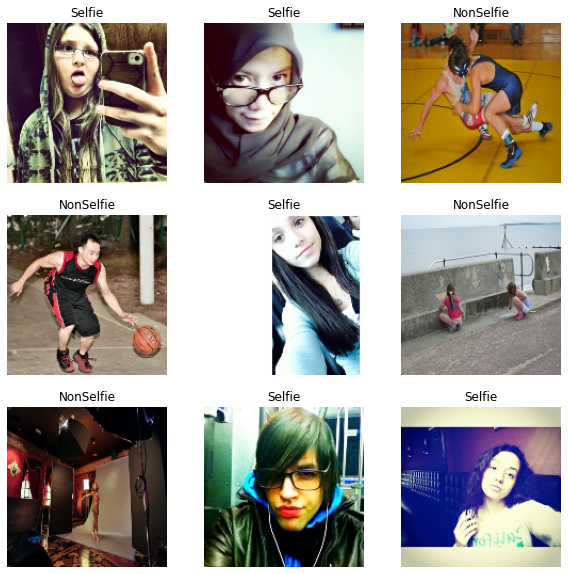

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
model = getModel()
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
print(acc)
print(val_acc)

TypeError: 'NoneType' object is not subscriptable

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/Users/brian/Documents/BISITE/Dataset/Selfie-Image-Detection-Dataset/Training_data",
        labels="inferred",
        label_mode="int",
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/brian/Documents/BISITE/Dataset/Selfie-Image-Detection-Dataset/Training_data",
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)

base_model.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.3, 0.3),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    ]
)

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
history = model.fit(train_ds, epochs=2, validation_data=val_ds)

Found 62895 files belonging to 2 classes.
Using 50316 files for training.
Found 62895 files belonging to 2 classes.
Using 12579 files for validation.
Epoch 1/2
1573/1573 [==============================] - 3438s 2s/step - loss: 0.1873 - binary_accuracy: 0.9257 - val_loss: 0.1257 - val_binary_accuracy: 0.9594
Epoch 2/2
1573/1573 [==============================] - 3268s 2s/step - loss: 0.1329 - binary_accuracy: 0.9487 - val_loss: 0.1212 - val_binary_accuracy: 0.9603


In [23]:
acc = history.history['binaryaccuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

KeyError: 'accuracy'